# 분류 실습 : 캐글 신용카드 사기 검출

Kaggle의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습  
데이터 다운로드 : www.kaggle.com에서 검색  
credit card fraud

신용카드 데이터 세트 특징
- 2013년 European Card 사용 트랜잭션을 가공해서 생성
- 불균형(Imbalanced)되어 있는 데이터 셋 284,807건의 데이터 중 492건이 Fraud(사기)

레이블인 Class 속성이 매우 불균형한 분포
- 0 값 : 정상 트랜잭선
- 1 값 : 사기 트랜잭션 (0.172 %)
    
일반적인 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 같은 데이터 세트는  
레이블 값이 극도로 불균형한 분포를 이룸  
사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적기 때문


Credit Card Falut Detection ML 모델 구축
- 다양한 Feature Engineering 방식을 
- Logistic Regression 알고리즘 이용 

Feature Engineering 
- 피처들 중 어떤 것이 모델링할 때 중요한 것인지 결정하는 과정
- 모델 성능에 미치는 영향이 크기 때문에 머신러닝 응용에 있어서 굉장히 중요한 단계이며
- 전문성과 시간과 비용이 많이 드는 작업
- PCA 방식 사용

PCA(Principal Component Analysis) 
- 대표적인 차원 축소 알고리즘
- 여러 변수 간 존재하는 상관관계를 이용해 차원을 축소하는 기법
- 간단하게 가장 높은 분산을 가지는 데이터의 축을 찾아 차원을 축소

차원 축소
- 많은 피처로 구성된 다차원의 데이터 셋을
- 차원을 축소하여 새로원 차원의 데이터 세트를 생성하는 것

Feature Engineering 주요 작업
- 주요 Feature의 데이터 분포도 변경
    - Log 변환
- 이상치(Outlier) 제거
- SMOTE 오버 샘플링

### 언더 샘플링과 오버 샘플링
- **레이블**이 불균형한 분포를 가진 데이터 세트를 학습 시 예측 성능의 문제 발생
- 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적어
- 다양한 유형을 학습하지 못하고 일방적으로 너무 많은 정상 레이블로 치우친 학습을 수행하게되는 문제


오버 샘플링
- 적은 레이블을 가진 데이터 세트를 많은 데이터 세트 수준으로 증식시키는 방식


언더 샘플링
- 많은 레이블을 가진 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식


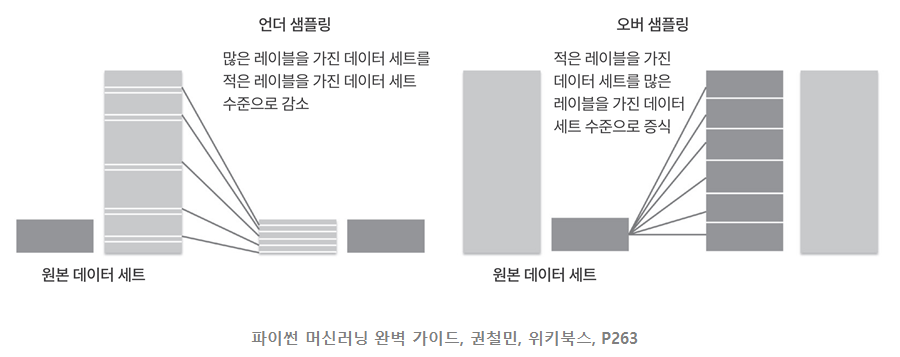

SMOTE(Synthetic Minority Over-sample Technique)
- 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾음
- K개 이웃들과의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이가 나는 새로운 데이터 생성 방식

SMOTE 수행 절차

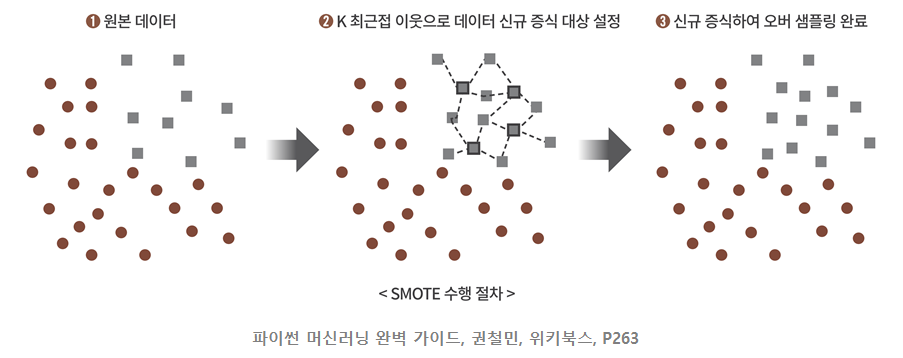

### 신용카드 사기 검출 예제 
- LogisticRegression 학습/예측/평가 수행
- 중요데이터 분포도 변환 학습/예측/평가 수행
    - 스케일링, 로그변환
- 이상치 데이터 제거 후, 학습/예측/평가 수행
- 오버샘플링 후, 학습/예측/평가 수행
- 분류 결정 임계값 이용해서 임계값 조정가능 여부 확인(시각화 이용)   
- 최종 모델 판단
- 이후, lightGBM 모델링

In [132]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

# import matplotlib.pyplot as plt
# import warnings

import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### 데이터 준비

In [133]:

card_df = pd.read_csv('./data/creditcard.csv')
card_df.head(3)

# Time : 크게 의미 있는 칼럼은 아님 데이터 만드는데 걸리는 시간 - 나중에 삭제
# v1~v28 속성 : 피처 이름이 전혀 들어가 있지 않음
# kaggle에서 칼럼 확인해보면
# 민감한 정보를 보호하기 위해서 PCA로 압축한 속성
# Amount : 카드 사용액
# Class : 0은 정상 사용, 1은 부정 카드 사용

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [65]:
card_df["Class"].value_counts()
# 타겟값 1의 레코드가 492개로 상당히 불균형한 데이터

Class
0    284315
1       492
Name: count, dtype: int64

In [66]:
card_df.describe()
card_df.info()
# 널값은 없음

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [67]:
# 불필요한 Time 열 삭제 후 원본 복사해서 사용
card_df.drop("Time", axis=1, inplace=True)

In [68]:
df_copy = card_df.copy()

### 데이터 세트 분리 함수 /  성능 평가 함수 사용

#### 데이터 세트 분리 함수  

In [69]:
from sklearn.model_selection import train_test_split

# 분리된 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df):
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    feature_data = df.iloc[:, :-1] # 피처 : 마지막 칼럼 전까지
    target_data = df.iloc[:, -1] # 레이블 : 마지막 칼럼
    
    # 데이터 세트 분리
    X_train, X_test, y_train, y_test = train_test_split(feature_data, 
                                                        target_data, 
                                                        test_size=0.3, 
                                                        random_state=0, 
                                                        stratify=target_data)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [70]:
# 데이터 세트 분리해주는 함수 호출하고 분리된 데이터 셋 받음
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)

print('학습 데이터 레이블 값 비율')
y_train.value_counts()
print(y_train.value_counts(normalize=True) * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts(normalize=True) * 100)

학습 데이터 레이블 값 비율


Class
0    199020
1       344
Name: count, dtype: int64

Class
0    99.827451
1     0.172549
Name: proportion, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: proportion, dtype: float64


#### 예측 모델 평가 수행 및 평가 지표 출력하는 함수

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score


# 예측 모델 평가 수행 및 평가 지표 출력하는 함수  앞에서 복사할 것)
def get_clf_eval(y_test, y_pred, pred_proba) :
    cm = confusion_matrix(y_test, y_pred) # 혼동행렬(오차행렬)
    accuracy = accuracy_score(y_test, y_pred) # 정확도
    precision = precision_score(y_test, y_pred) # 정밀도
    recall = recall_score(y_test, y_pred)# 재현율
    f1 = f1_score(y_test, y_pred) # F1 스코어
    roc_auc = roc_auc_score(y_test, pred_proba) # ROC_AUC 스코어
    
    # 출력 
    # 오차행렬
    print("오차행렬 : ", cm)
    # 정확도, 정밀도, 재현율, F1
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1 Score: {f1:.4f}, ROC_AUC : {roc_auc:.4f}")

### LogisticRegression  학습/예측/평가 수행

In [72]:
from sklearn.linear_model import LogisticRegression

# 데이터 세트 분리 함수 호출
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)


# 모델 생성 
lr_clf = LogisticRegression(solver="liblinear")
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

# 평가
pred_proba=lr_clf.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, y_pred, pred_proba)



# 오차행렬 :  [[85282    13]
#  [   58    90]]
# 정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081, F1 Score: 0.7171, ROC_AUC : 0.9709

LogisticRegression(solver='liblinear')

오차행렬 :  [[85282    13]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081, F1 Score: 0.7171, ROC_AUC : 0.9709


### 중요 데이터 분포도 변환 후 모델 학습/예측/평가


- Amount 피처는 신용 카드 사용 금액으로 
- 정상/사기 트랜잭션을 결정하는 중요 속성일 가능성 높음 
- 다른 피처들은 PCA 압축한 속성  


In [73]:
df_copy["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

<Figure size 800x400 with 0 Axes>

([<matplotlib.axis.XTick at 0x1b44da5f830>,
 [Text(0, 0, '0'),
  Text(1000, 0, '1000'),
  Text(2000, 0, '2000'),
  Text(3000, 0, '3000'),
  Text(4000, 0, '4000'),
  Text(5000, 0, '5000'),
  Text(6000, 0, '6000'),
  Text(7000, 0, '7000'),
  Text(8000, 0, '8000'),
  Text(9000, 0, '9000'),
  Text(10000, 0, '10000'),
  Text(11000, 0, '11000'),
  Text(12000, 0, '12000'),
  Text(13000, 0, '13000'),
  Text(14000, 0, '14000'),
  Text(15000, 0, '15000'),
  Text(16000, 0, '16000'),
  Text(17000, 0, '17000'),
  Text(18000, 0, '18000'),
  Text(19000, 0, '19000'),
  Text(20000, 0, '20000'),
  Text(21000, 0, '21000'),
  Text(22000, 0, '22000'),
  Text(23000, 0, '23000'),
  Text(24000, 0, '24000'),
  Text(25000, 0, '25000'),
  Text(26000, 0, '26000'),
  Text(27000, 0, '27000'),
  Text(28000, 0, '28000'),
  Text(29000, 0, '29000')])

<Axes: xlabel='Amount', ylabel='Density'>

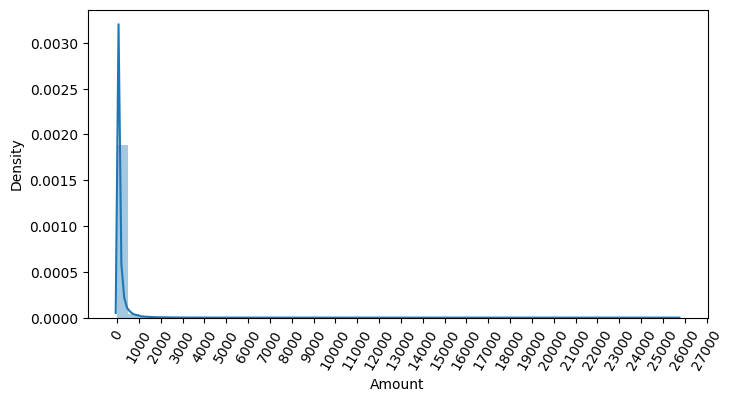

In [74]:
# 중요 속성으로 Amount 선정해서 분포도 확인

import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df["Amount"])
plt.show()
# 대부분의 금액이 500유로 이하인데 금액 데이터 몇개가 26000정도까지 분포되어 있음
# 오른쪽으로 꼬리가 긴 상당히 불균형한 컬럼 데이터

####  Amount 피처에 표준 스케일링 적용

In [75]:
from sklearn.preprocessing import StandardScaler

df_copy = card_df.copy()

scaler = StandardScaler()
amount_sc = scaler.fit_transform(df_copy[["Amount"]]) # 표준변환 진행 시, df형태로 전달해야함, series로 전달하면 오류
df_copy.insert(0, "Amount_scaled", amount_sc) # insert로 하면 그 컬럼의 위치도 지정해줄 수 있음

In [76]:
df_copy.head(2)

,Amount_scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


### Amount 값 스케일링 후 모델 학습/예측/평가

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 

def get_clf_eval(y_test, y_pred, pred_proba) :
    cm = confusion_matrix(y_test, y_pred) # 혼동행렬(오차행렬)
    accuracy = accuracy_score(y_test, y_pred) # 정확도
    precision = precision_score(y_test, y_pred) # 정밀도
    recall = recall_score(y_test, y_pred)# 재현율
    f1 = f1_score(y_test, y_pred) # F1 스코어
    roc_auc = roc_auc_score(y_test, pred_proba) # ROC_AUC 스코어
    
    # 출력 
    # 오차행렬
    print("오차행렬 : ", cm)
    # 정확도, 정밀도, 재현율, F1
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f},  재현율: {recall:.4f}, F1 Score: {f1:.4f}, ROC_AUC : {roc_auc:.4f}")
    

In [78]:
# 로지스틱 회귀 
from sklearn.linear_model import LogisticRegression

print('로지스틱 회귀 예측 성능 : Amount 컬럼 표준 스케일링')
# 데이터 세트 분리 함수 호출
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)
X_train = X_train.iloc[:, :-1]
X_test = X_test.iloc[:, :-1]
X_train.head()

로지스틱 회귀 예측 성능 : Amount 컬럼 표준 스케일링


,Amount_scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
211605,-0.350471,-8.367621,7.402969,-5.114191,-2.966792,-0.985904,-1.660018,0.397816,1.008250,5.290976,...,-0.750795,3.589299,-0.557927,0.349087,0.301734,0.662330,1.145939,-0.012273,1.513736,0.669504
231628,-0.131456,-1.290662,0.764452,-0.169233,-1.688528,1.984718,-0.717210,1.667635,-0.228295,-0.959071,...,-0.059595,0.057620,0.138615,0.390374,-0.678774,0.292254,1.425865,0.265341,0.051405,0.103879
110643,-0.307251,-0.606860,0.233923,2.633361,-0.155762,-0.328850,-0.070593,0.173023,0.113394,0.680147,...,-1.003842,-0.129287,0.007393,0.265045,-0.040615,0.406088,-0.498823,0.121851,-0.046840,-0.087259
11478,-0.313249,1.374168,-0.330389,0.812971,-0.183112,-1.074771,-0.933788,-0.544238,-0.348237,0.614925,...,0.603330,0.078163,-0.134742,0.016793,0.002610,0.714527,0.536175,-0.307487,-0.003555,0.013024
243724,8.802588,-2.146505,-7.603113,-4.928224,1.449173,-2.083871,-0.984759,3.629816,-1.302973,-1.434148,...,-1.373723,4.009181,1.274986,-0.857670,-2.109682,0.169338,-0.322888,0.777822,-0.552258,0.304777


In [79]:
# 모델 생성
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)

# 스케일링 적용 전 
# 오차행렬 :  [[85282    13]
#  [   58    90]]
# 정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081, F1 Score: 0.7171, ROC_AUC : 0.9709

# 스케일링 적용 후
# 오차행렬 :  [[85280    15]
#  [   59    89]]
# 정확도: 0.9991, 정밀도: 0.8558,  재현율: 0.6014, F1 Score: 0.7063, ROC_AUC : 0.9659

# 스케일링 전/후 별 차이 없음
# 아직도 재현율이 만족스럽지 못함 

LogisticRegression(solver='liblinear')

오차행렬 :  [[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654,  재현율: 0.6081, F1 Score: 0.7143, ROC_AUC : 0.9707


#### Amount를 로그 변환 

In [80]:
df_copy = card_df.copy()
amount_log = np.log1p(df_copy["Amount"])
df_copy.insert(0, "Amount_log", amount_log)

In [81]:
df_copy.head(2)

,Amount_log,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,5.014760,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.305626,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


### 로그변환 후 모델링 

In [82]:
# 로지스틱 회귀 
from sklearn.linear_model import LogisticRegression

print('로지스틱 회귀 예측 성능')
# 데이터 세트 분리 함수 호출
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)
X_train = X_train.iloc[:, :-1]
X_test = X_test.iloc[:, :-1]
X_train.head(2)

로지스틱 회귀 예측 성능


,Amount_log,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
211605,0.524729,-8.367621,7.402969,-5.114191,-2.966792,-0.985904,-1.660018,0.397816,1.008250,5.290976,...,-0.750795,3.589299,-0.557927,0.349087,0.301734,0.662330,1.145939,-0.012273,1.513736,0.669504
231628,4.033710,-1.290662,0.764452,-0.169233,-1.688528,1.984718,-0.717210,1.667635,-0.228295,-0.959071,...,-0.059595,0.057620,0.138615,0.390374,-0.678774,0.292254,1.425865,0.265341,0.051405,0.103879


In [83]:
# 모델 생성
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)

## 로그변환 전
# 스케일링 적용 전 
# 오차행렬 :  [[85282    13]
#  [   58    90]]
# 정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081, F1 Score: 0.7171, ROC_AUC : 0.9709

# 스케일링 적용 후
# 오차행렬 :  [[85280    15]
#  [   59    89]]
# 정확도: 0.9991, 정밀도: 0.8558,  재현율: 0.6014, F1 Score: 0.7063, ROC_AUC : 0.9659


## 로그변환 후
# 오차행렬 :  [[85283    12]
#  [   58    90]]
# 정확도: 0.9992, 정밀도: 0.8824,  재현율: 0.6081, F1 Score: 0.7200, ROC_AUC : 0.9721

# 로그 변환 후 재현율이 약간 상승했지만 아직도 만족스러운 수치는 아니라고 판단 

LogisticRegression(solver='liblinear')

오차행렬 :  [[85283    12]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8824,  재현율: 0.6081, F1 Score: 0.7200, ROC_AUC : 0.9721


#### 표준스케일링과 로그 변환을 동시에 적용해서 모델링

### 이상치 데이터 제거 후 모델 학습/예측/평가

- 각 피처들의 상관 관계를 시각화
- 결정 레이블인 class 값과 가장 상관도가 높은 피처 추출 
- 상관도가 높은 피처들에 대해서 아웃 라이어(이상치) 찾아서    
- 이상치가 높은 피처들의 행 삭제  

<Figure size 1000x1000 with 0 Axes>

<Axes: >

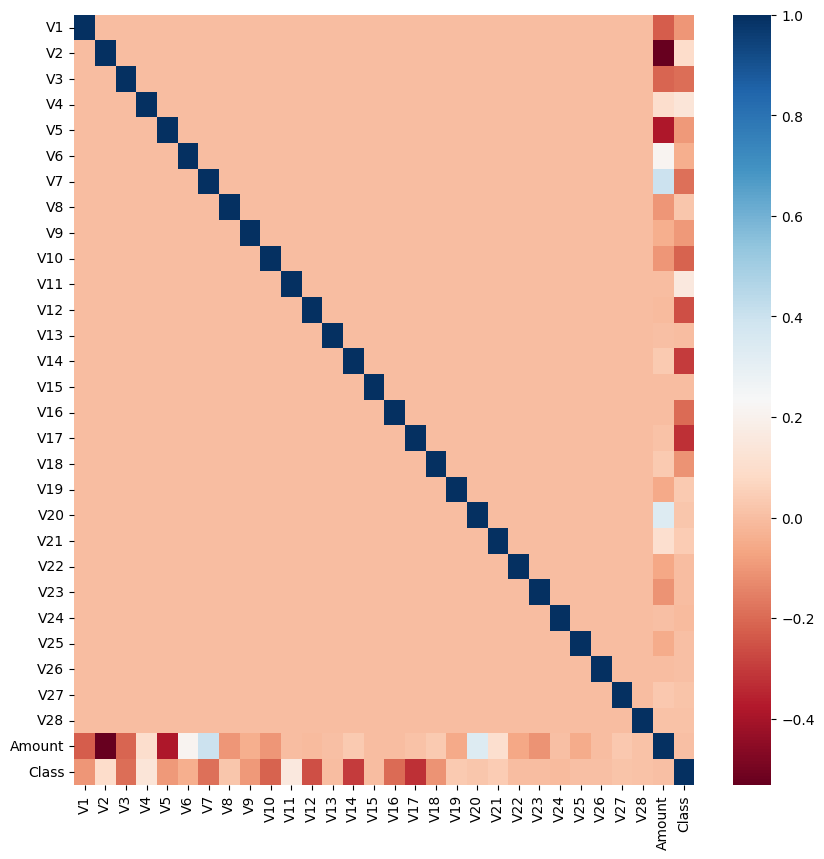

In [91]:
import seaborn as sns
corr = card_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap="RdBu")
plt.show()



# Class 값과 상관도가 높은 피처를 찾아서 확인 : X축에서 v12, v14, v17 (짙은 빨간색)
# 이 중에서 v14에 해당되는 이상치를 찾아 확인해 볼 것 

### IQR을 이용해 이상치 데이터 검출
- IQR*1.5해서 최대값과 최소값 결정
- 이상치 : 최대값 초과 또는 최소값 미만 데이터    

In [96]:
# 이상치를 찾기 위한 함수 새로 생성

import numpy as np

# 전체 데이터에서 찾지 않고 사기 데이터 (Class가 1인)에서 찾음 >> 사기 데이터의 분포에서만 이상치를 확인
# 최대, 최소값을 벗어난 값을 이상치로 간주하고 이상치 인덱스 찾아서 반환
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df["Class"]==1][column] 
    quantile_25 = np.percentile(fraud.values, 25) # == np.quantile(fraud.values, 0.25)
    quantile_75 = np.percentile(fraud.values, 75) # == np.quantile(fraud.values, 0.75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    higher_val = quantile_75+iqr_weight
    lower_val = quantile_25-iqr_weight
    
    outlier_index = fraud[(fraud<lower_val)|(fraud>higher_val)].index
    return outlier_index
    

In [97]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)
# 4개 인덱스 : 이 인덱스에 해당되는 행은 삭제할 것임

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [ ]:
get_outlier(df=card_df, column='V12', weight=1.5)
get_outlier(df=card_df, column='V17', weight=1.5)

**로그 변환 후 V14 피처의 이상치 데이터를 삭제한 뒤 모델들을 재 학습/예측/평가**

In [112]:
df_copy = card_df.copy()

# 로그변환 
amount = np.log1p(df_copy["Amount"])
df_copy.insert(0, "Amount_log", amount)

# 이상치 데이터 삭제
outlier_index = get_outlier(df=df_copy, column="V14", weight=1.5)
df_copy.drop(outlier_index, axis=0, inplace=True)
df_copy.head(3)

,Amount_log,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,5.014760,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.305626,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,5.939276,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [113]:
# 이상치 데이터 삭제
# outlier_index = get_outlier(df=df_copy, column="V12", weight=1.5)
# df_copy.drop(outlier_index, axis=0, inplace=True)
# df_copy.head(3)

In [114]:
# 로지스틱 회귀 
from sklearn.linear_model import LogisticRegression

print('로지스틱 회귀 예측 성능')
# 데이터 세트 분리 함수 호출
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)

# 모델 생성
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)

# 로그변환 후 이상치 제거 전
# 오차행렬 :  [[85271    24]
#  [   51    97]]
# 정확도: 0.9991, 정밀도: 0.8017,  재현율: 0.6554, F1 Score: 0.7212, ROC_AUC : 0.9346

# 로그변환 후 V14 컬럼의 이상치 제거 후
# 오차행렬 :  [[85280    15]
#  [   48    98]]
# 정확도: 0.9993, 정밀도: 0.8673,  재현율: 0.6712, F1 Score: 0.7568, ROC_AUC : 0.9743

# 전체적으로 다른 지표는 약간 수치가 올랐지만 재현율은 약간 떨어짐 
# 재현율이 만족스럽지 못함 

# 로그변환 후 V12 컬럼의 이상치 추가 제거 후
# 오차행렬 :  [[85280    15]
#  [   49    96]]
# 정확도: 0.9993, 정밀도: 0.8649,  재현율: 0.6621, F1 Score: 0.7500, ROC_AUC : 0.9680

# 회귀방식을 사용하는 모델인 경우에는 이상치에 민감하게 반응 >> 이상치 제거가 회귀모델에서는 효과적일수 있음
# 사기 데이터가 얼마 안되는 상황에서 이상치 제거로 데이터 수 감소
# V12는 타겟값과의 상관성이 아주 높은 컬럼은 아님 >> 영향이 미비한데 데이터만 삭제해서 학습량 감소만 유발

# >> 결론 : 12 이상치는 삭제하지 않고 14 이상치만 제거

로지스틱 회귀 예측 성능


LogisticRegression(solver='liblinear')

오차행렬 :  [[85280    15]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8673,  재현율: 0.6712, F1 Score: 0.7568, ROC_AUC : 0.9743


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

- SMOTE 적용 시 **반드시 학습 데이터 세트만 오버 샘플링 수행**  
- 검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 
  - 결국 원본 데이터 세트가 아닌 
    - 변형된 데이터 세트에서 검증 또는 테스트를 수행하기 때문에  
    - 올바른 검증/테스트가 될 수 없음   
---
SMOTE 방식을 제공하는 패키지 : imblearn.over_sampling (imbalanced learn)  
imbalanced-learn 설치 필요  

In [116]:
# !pip install -U imbalanced-learn

In [38]:
# 불균형 데이터를 다루기 위한 패키지 imblearn 설치
# imblearn 설치
# Anaconda Prompt에서
# 가상환경 활성화하고 : conda activate MLenv
# 설치 : pip install -U imbalanced-learn


In [117]:
import imblearn
imblearn.__version__

'0.13.0'

In [118]:
from imblearn.over_sampling import SMOTE

df_copy = card_df.copy()

# 데이터 세트 분리 함수 호출
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)

# 오버 샘플링
smote = SMOTE(random_state= 0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# 전체 데이터 :284,807
# 테스트 : 30%, 학습 : 70% (199,364)
print('SMOT 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOT 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOT 적용 후 레이블 값 분포: ', pd.Series(y_train_over).value_counts())



SMOT 적용 전 학습용 피처/레이블 데이터 세트:  (199364, 29) (199364,)
SMOT 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOT 적용 후 레이블 값 분포:  Class
0    199020
1    199020
Name: count, dtype: int64


In [119]:
# SMOT 적용 전 레이블 값 분포
y_train.value_counts()

Class
0    199020
1       344
Name: count, dtype: int64

#### 로지스틱 회귀로 학습/예측/평가 **

In [120]:
# 오버샘플링 후 로지스틱 회귀 
from sklearn.linear_model import LogisticRegression

print('로지스틱 회귀 예측 성능')

# 모델 생성
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train_over, y_train_over) # 오버샘플링된 데이터로 학습

y_pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)


# 오버샘플링 후 결과 
# 오차행렬 :  [[84048  1247]
#  [   17   131]]
# 정확도: 0.9852, 정밀도: 0.0951,  재현율: 0.8851, F1 Score: 0.1717, ROC_AUC : 0.9797

# 재현율 (0.8851) : 무척 좋아졌음 
# 정밀도 (0.0951) : 엄청 떨어졌음 
# F1 Score (0.1717) : 재현율과 정밀도 불균형 

# 재현율이 높더라도 정밀도 너무 낮기 때문에 실제로는 사용할 수 없는 모듈로 판단 
# 오버샘플링으로 인해 원본 데이터보다 너무 많는 class=1 데이터를 학습하면서
# 실제 테스트 데이터 세트에 제대로 예측하지 못했음 >> 과적합 상태로 보여짐

# Precision-Recall 곡선에서 임계값에 따라 정밀도와 재현율의 조정이 가능한지 확인

로지스틱 회귀 예측 성능


LogisticRegression(solver='liblinear')

오차행렬 :  [[84048  1247]
 [   17   131]]
정확도: 0.9852, 정밀도: 0.0951,  재현율: 0.8851, F1 Score: 0.1717, ROC_AUC : 0.9797


#### Precision-Recall 곡선 시각화 **

In [121]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba): 
    precision, reacalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    threshold_boundary = thresholds.shape[0]
    # x축은 thresholds 값, y축은 정밀도, 재현율  값으로 plot() 
    plt.plot(thresholds, precision[0:threshold_boundary], 
             linestyle='--', label='precision')

    plt.plot(thresholds, reacalls[0:threshold_boundary], label='reacall')

    # thresholds 값 x축 : 0, 1 단위로 변경
    # xlim() : x축  범위 지정|
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Thresholds Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

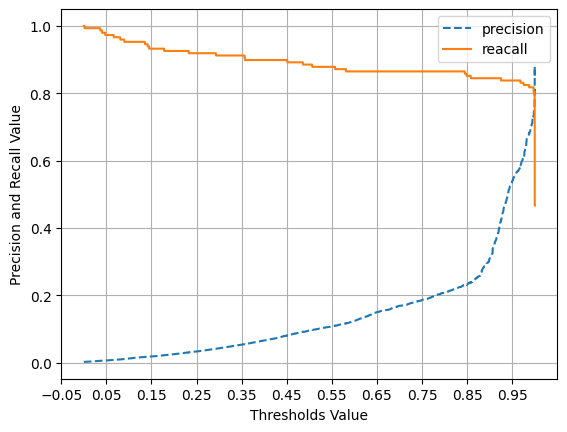

In [122]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )



### 결론
- 임계점 변경은 불가능해보임
    - 정밀도가 계속 낮은 값을 유지하다가 0.98정도에서 급상승함 >> 원래 1에 가까울수록 높아지는게 맞음
    - 따라서 임계점 변경을 진행할 경계값이 없음
- 로지스틱 회귀 모델에서는 SMOTE 적용한 경우 올바른 예측모델을 생성할 수 없음
    - 부적합 모델로 판단
- 다른 알고리즘을 적용해서 모델 생성하는 것으로 판단

In [45]:
# Light GBM 설치
# Anaconda Prompt에서
# 가상환경 활성화하고 : conda activate MLenv
# 설치 : pip install lightgbm

In [124]:
# !pip install lightgbm

In [46]:
# 불필요한 Time 열 삭제 후 원본 복사해서 사용
# card_df.drop('Time', axis=1, inplace=True)
df_copy = card_df.copy()

X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)

#### LightGBM 모델 적용 **

In [ ]:
# boost_from_average=False : 불균형한 데이터 세트에서 예측 성능이 매우 저조할 경우 
# LightGBM 객체 생성 시 boost_from_average = False로 파라미터를 설정
# True 값으로 설정할 경우 재현율과 roc_auc_score가 매우 낮아짐 

# force_col_wise=True
# 메모리 용량이 충분하지 않을 때 메모리 효율을 높이는 파라미터

# early_stopping : 조기 종료. 지정된 라운드 동안 성능 개선이 없으면 학습 중단  
# callbacks : 학습 중 자동으로 수행할 작업(함수) 지정
# log_evaluation : 로그 출력 콜백. 지정된 주기마다 평가지표 출력
# logloss: 분류 모델 평가 지표. 잘못 분류된 손실값(loss) 계산하는 함수
# eval_metrics: 평가 지표 지정 
# eval_set: 모델 학습 중 성능 평가를 위한 검증 데이터 세트 설정


In [134]:
card_df = pd.read_csv('./data/creditcard.csv')
card_df.drop('Time', axis=1, inplace=True)

In [135]:
# (1) 아무 것도 하지 않은 경우
# 로그변환 (X) / 이상치 제거 (X) / 오버샘플링 (X) / early_stopping(100) (X) 
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

df_copy = card_df.copy()
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)

print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=400,
                         boost_from_average=False,
                         fore_col_wise=True) # 모델 객체 생성시 주입되는 파라미터
eval_data = [(X_test, y_test)]

lgbm_clf.fit(X_train, y_train,
             callbacks=[log_evaluation()],
             eval_metric="logloss",
             eval_set=eval_data)
y_pred = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)
# 오차행렬 :  [[85291     4]
#  [   37   111]]
# 정확도: 0.9995, 정밀도: 0.9652,  재현율: 0.7500, F1 Score: 0.8441, ROC_AUC : 0.9805

LightGBM 예측 성능
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[1]	valid_0's binary_logloss: 0.598339
[2]	valid_0's binary_logloss: 0.520683
[3]	valid_0's binary_logloss: 0.455938
[4]	valid_0's binary_logloss: 0.401211
[5]	valid_0's binary_logloss: 0.35447
[6]	valid_0's binary_logloss: 0.314202
[7]	valid_0's binary_logloss: 0.279286
[8]	valid_0's binary_logloss: 0.248827
[9]	valid_0's binary_logloss: 0.222144
[10]	valid_0's binary_logloss: 0.198675
[11]	valid_0's binary_logloss: 0.177951
[12]	valid_0's binary_logloss: 0.

LGBMClassifier(boost_from_average=False, fore_col_wise=True, n_estimators=400)

[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
오차행렬 :  [[85291     4]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9652,  재현율: 0.7500, F1 Score: 0.8441, ROC_AUC : 0.9805


In [136]:
# (2) 로그변환 (X) / 이상치 제거 (X) / 오버샘플링 (O) / early_stopping(100) (X) 

from lightgbm import LGBMClassifier, early_stopping, log_evaluation

df_copy = card_df.copy()
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)

# 오버 샘플링
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=400,
                         boost_from_average=False,
                         fore_col_wise=True) # 모델 객체 생성시 주입되는 파라미터
eval_data = [(X_test, y_test)]

lgbm_clf.fit(X_train, y_train,
             callbacks=[log_evaluation()],
             eval_metric="logloss",
             eval_set=eval_data)
y_pred = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)


# 오차행렬 :  [[85291     4]
#  [   37   111]]
# 정확도: 0.9995, 정밀도: 0.9652,  재현율: 0.7500, F1 Score: 0.8441, ROC_AUC : 0.9805


LightGBM 예측 성능
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[1]	valid_0's binary_logloss: 0.598339
[2]	valid_0's binary_logloss: 0.520683
[3]	valid_0's binary_logloss: 0.455938
[4]	valid_0's binary_logloss: 0.401211
[5]	valid_0's binary_logloss: 0.35447
[6]	valid_0's binary_logloss: 0.314202
[7]	valid_0's binary_logloss: 0.279286
[8]	valid_0's binary_logloss: 0.248827
[9]	valid_0's binary_logloss: 0.222144
[10]	valid_0's binary_logloss: 0.198675
[11]	valid_0's binary_logloss: 0.177951
[12]	valid_0's binary_logloss: 0.

LGBMClassifier(boost_from_average=False, fore_col_wise=True, n_estimators=400)

[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
오차행렬 :  [[85291     4]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9652,  재현율: 0.7500, F1 Score: 0.8441, ROC_AUC : 0.9805
LightGBM 예측 성능


In [140]:
# (3) 로그변환 (X) / 이상치 제거 (X) / 오버샘플링 (O) / early_stopping(100) (O) 

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from imblearn.over_sampling import SMOTE

df_copy = card_df.copy()
X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)

# 오버 샘플링
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=400,
                         boost_from_average=False,
                         fore_col_wise=True) # 모델 객체 생성시 주입되는 파라미터
eval_data = [(X_test, y_test)]

lgbm_clf.fit(X_train_over, y_train_over,
             callbacks=[early_stopping(100)], # 최소 100번은 실행할건데 후에 성능변화 없으면 조기종료
             eval_metric="logloss",
             eval_set=eval_data)
y_pred = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)

# 오차행렬 :  [[85233    62]
#  [   23   125]]
# 정확도: 0.9990, 정밀도: 0.6684,  재현율: 0.8446, F1 Score: 0.7463, ROC_AUC : 0.9779

LightGBM 예측 성능
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] Unknown parameter: fore_col_wise
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.00444271


LGBMClassifier(boost_from_average=False, fore_col_wise=True, n_estimators=400)

[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
오차행렬 :  [[85233    62]
 [   23   125]]
정확도: 0.9990, 정밀도: 0.6684,  재현율: 0.8446, F1 Score: 0.7463, ROC_AUC : 0.9779


In [141]:
# (4) 로그변환 (O) / 이상치 제거 (O) / 오버샘플링 (X) / early_stopping(100) (X) 

df_copy = card_df.copy()

# 로그변환
amount = np.log1p(df_copy["Amount"])
df_copy.insert(0, "Amount_log", amount)

# 이상치 삭제
outlier_index = get_outlier(df=df_copy, column="V14", weight=1.5)
df_copy.drop(outlier_index, axis=0, inplace=True)

X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)
X_train = X_train.iloc[:, :-1] # 기존 Amount컬럼은 삭제하고
X_test = X_test.iloc[:, :-1]

print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=400,
                         boost_from_average=False,
                         fore_col_wise=True) # 모델 객체 생성시 주입되는 파라미터
eval_data = [(X_test, y_test)]

lgbm_clf.fit(X_train, y_train,
             callbacks=[log_evaluation()], # 최소 100번은 실행할건데 후에 성능변화 없으면 조기종료
             eval_metric="logloss",
             eval_set=eval_data)
y_pred = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)


# 로그변환, 이상치 제거 후 실행시 성능이 극히 하락함을 확인
# 오차행렬 :  [[85172   123]
#  [   97    49]]
# 정확도: 0.9974, 정밀도: 0.2849,  재현율: 0.3356, F1 Score: 0.3082, ROC_AUC : 0.6704

LightGBM 예측 성능
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[1]	valid_0's binary_logloss: 0.598311
[2]	valid_0's binary_logloss: 0.520649
[3]	valid_0's binary_logloss: 0.455898
[4]	valid_0's binary_logloss: 0.401157
[5]	valid_0's binary_logloss: 0.354397
[6]	valid_0's binary_logloss: 0.314118
[7]	valid_0's binary_logloss: 0.27918
[8]	valid_0's binary_logloss: 0.248711
[9]	valid_0's binary_logloss: 0.222018
[10]	valid_0's binary_logloss: 0.198531
[11]	valid_0's binary_logloss: 0.177809
[12]	valid_0's binary_logloss: 0.

LGBMClassifier(boost_from_average=False, fore_col_wise=True, n_estimators=400)

[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
오차행렬 :  [[85172   123]
 [   97    49]]
정확도: 0.9974, 정밀도: 0.2849,  재현율: 0.3356, F1 Score: 0.3082, ROC_AUC : 0.6704


In [142]:
# (5) 로그변환 (O) / 이상치 제거 (O) / 오버샘플링 (O) / early_stopping(100) (X) 

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from imblearn.over_sampling import SMOTE

df_copy = card_df.copy()

# 로그변환
amount = np.log1p(df_copy["Amount"])
df_copy.insert(0, "Amount_log", amount)

# 이상치 삭제
outlier_index = get_outlier(df=df_copy, column="V14", weight=1.5)
df_copy.drop(outlier_index, axis=0, inplace=True)

X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)
X_train = X_train.iloc[:, :-1] # 기존 Amount컬럼은 삭제하고
X_test = X_test.iloc[:, :-1]

# 오버샘플링
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

lgbm_clf = LGBMClassifier(n_estimators=400,
                         boost_from_average=False,
                         fore_col_wise=True) # 모델 객체 생성시 주입되는 파라미터
eval_data = [(X_test, y_test)]

lgbm_clf.fit(X_train_over, y_train_over,
             callbacks=[log_evaluation()], # 최소 100번은 실행할건데 후에 성능변화 없으면 조기종료
             eval_metric="logloss",
             eval_set=eval_data)
y_pred = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)

# 로그변환, 이상치제거, 오버샘플링 적용 후
# 오차행렬 :  [[85278    17]
#  [   23   123]]
# 정확도: 0.9995, 정밀도: 0.8786,  재현율: 0.8425, F1 Score: 0.8601, ROC_AUC : 0.9711
# 정밀도, 재현율이 높은 수치로 균형있게 평가됨, 정밀도가 살짝 높아도 타협이 가능한 정도의 차이 이므로
# 지금까지 모델 중 가장 평가성능이 좋은 모델로 보임

[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[1]	valid_0's binary_logloss: 0.607711
[2]	valid_0's binary_logloss: 0.537558
[3]	valid_0's binary_logloss: 0.479548
[4]	valid_0's binary_logloss: 0.429977
[5]	valid_0's binary_logloss: 0.386006
[6]	valid_0's binary_logloss: 0.348927
[7]	valid_0's binary_logloss: 0.316426
[8]	valid_0's binary_logloss: 0.287529
[9]	valid_0's binary_logloss: 0.262474
[10]	valid_0's binary_logloss: 0.239605
[11]	valid_0's binary_logloss: 0.219874
[12]	valid_0's binary_logloss: 0.20242
[13]	

LGBMClassifier(boost_from_average=False, fore_col_wise=True, n_estimators=400)

[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
오차행렬 :  [[85278    17]
 [   23   123]]
정확도: 0.9995, 정밀도: 0.8786,  재현율: 0.8425, F1 Score: 0.8601, ROC_AUC : 0.9711


In [143]:
# (6) # 로그변환 (O) / 이상치 제거 (O) / 오버샘플링 (O) / early_stopping(100) (O) 
df_copy = card_df.copy()

# 로그변환
amount = np.log1p(df_copy["Amount"])
df_copy.insert(0, "Amount_log", amount)

# 이상치 삭제
outlier_index = get_outlier(df=df_copy, column="V14", weight=1.5)
df_copy.drop(outlier_index, axis=0, inplace=True)

X_train, X_test, y_train, y_test = get_train_test_dataset(df_copy)
X_train = X_train.iloc[:, :-1] # 기존 Amount컬럼은 삭제하고
X_test = X_test.iloc[:, :-1]

# 오버샘플링
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

lgbm_clf = LGBMClassifier(n_estimators=400,
                         boost_from_average=False,
                         fore_col_wise=True) # 모델 객체 생성시 주입되는 파라미터
eval_data = [(X_test, y_test)]

lgbm_clf.fit(X_train_over, y_train_over,
             callbacks=[early_stopping(100)], # 최소 100번은 실행할건데 후에 성능변화 없으면 조기종료
             eval_metric="logloss",
             eval_set=eval_data)
y_pred = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, y_pred, pred_proba)

# 오차행렬 :  [[85269    26]
#  [   23   123]]
# 정확도: 0.9994, 정밀도: 0.8255,  재현율: 0.8425, F1 Score: 0.8339, ROC_AUC : 0.9722

# 정밀도가 조기종료 전보다 떨어졌지만
# 데이터 특성상 재현율이 중요한 데이터이므로
# 재현율이 정밀도보다 높고
# 정밀도 재현율 모두 높은 수치로 나타나고 있으므로 모델로 적합해보임

[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] Unknown parameter: fore_col_wise
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.0042248


LGBMClassifier(boost_from_average=False, fore_col_wise=True, n_estimators=400)

[LightGBM] [Warning] Unknown parameter: fore_col_wise
[LightGBM] [Warning] Unknown parameter: fore_col_wise
오차행렬 :  [[85269    26]
 [   23   123]]
정확도: 0.9994, 정밀도: 0.8255,  재현율: 0.8425, F1 Score: 0.8339, ROC_AUC : 0.9722


In [ ]:
# (1) 아무 것도 하지 않은 경우
# 로그변환 (X) / 이상치 제거 (X) / 오버샘플링 (X) / early_stopping(100) (X) 
# 오차행렬 :  [[85291     4]
#  [   37   111]]
# 정확도: 0.9995, 정밀도: 0.9652,  재현율: 0.7500, F1 Score: 0.8441, ROC_AUC : 0.9805
# 정밀도에 비해 재현율이 너무 낮음


# (2) 로그변환 (X) / 이상치 제거 (X) / 오버샘플링 (O) / early_stopping(100) (X) 
# 오차행렬 :  [[85285    10]
#  [   32   116]]
# 정확도: 0.9995, 정밀도: 0.9206,  재현율: 0.7838, F1 Score: 0.8467, ROC_AUC : 0.9552
# 정밀도에 비해 재현율이 너무 낮음


# (3) 로그변환 (X) / 이상치 제거 (X) / 오버샘플링 (O) / early_stopping(100) (O) 
# 오차행렬 :  [[85233    62]
#  [   23   125]]
# 정확도: 0.9990, 정밀도: 0.6684,  재현율: 0.8446, F1 Score: 0.7463, ROC_AUC : 0.9779
# 재현율은 상당히 향상되었지만 정밀도가 많이 낮아졌고, 따라서 F1 Score 수치도 낮아짐 
# 사기 검출 데이터에서는 재현율에 초점을 맞춰서 진행하는 것이 더 좋으므로 
# 정밀도와 F1 Score를 희생하더라도 재현율을 높이는 것이 바람직함 



# (4) 로그변환 (O) / 이상치 제거 (O) / 오버샘플링 (X) / early_stopping(100) (X) 
# 오차행렬 :  [[85288     7]
#  [   29   116]]
# 정확도: 0.9996, 정밀도: 0.9431,  재현율: 0.8000, F1 Score: 0.8657, ROC_AUC : 0.9735



# (5) 로그변환 (O) / 이상치 제거 (O) / 오버샘플링 (O) / early_stopping(100) (X) 
# 오차행렬 :  [[85278    17]
#  [   23   123]]
# 정확도: 0.9995, 정밀도: 0.8786,  재현율: 0.8425, F1 Score: 0.8601, ROC_AUC : 0.9711
# 정밀도, 재현율이 높은 수치로 균형있게 평가됨, 정밀도가 살짝 높아도 타협이 가능한 정도의 차이 이므로
# 지금까지 모델 중 가장 평가성능이 좋은 모델로 보임


# (6) # 로그변환 (O) / 이상치 제거 (O) / 오버샘플링 (O) / early_stopping(100) (O) 
# 오차행렬 :  [[85269    26]
#  [   23   123]]
# 정확도: 0.9994, 정밀도: 0.8255,  재현율: 0.8425, F1 Score: 0.8339, ROC_AUC : 0.9722

# 정밀도가 조기종료 전보다 떨어졌지만
# 데이터 특성상 재현율이 중요한 데이터이므로
# 재현율이 정밀도보다 높고
# 정밀도 재현율 모두 높은 수치로 나타나고 있으므로 모델로 적합해보임

### **주의사항**
- 검증데이터를 학습데이터에서 분리해서 사용해야함
- 이 모델은 검증데이터를 평가데이터로 사용함
- 모델이 한번 경험했던 평가데이터 일 수 있음
- 최종성능에서 약간 성능이 감소할 수도 있음